# Summary
You are tasked with unsupervised anomaly detection on raw network‐flow data in order to flag potential intrusions without having any labels during training. Concretely, given a large CSV of network connections (features like duration, protocol, bytes sent/received, etc.), your goal is to:

* Learn the “normal” joint behavior of these features in an unsupervised way.
* Assign an outlier score to each connection indicating how anomalous it is.
* Validate your approach against a held-out test set (with labels only for evaluation, not for training).

# Data pre-processing

In [169]:
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Field%20Names.csv

--2025-06-09 19:27:33--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘KDDTrain+.txt.5’

KDDTrain+.txt.5     100%[===================>]  18.22M   106MB/s    in 0.2s    

2025-06-09 19:27:33 (106 MB/s) - ‘KDDTrain+.txt.5’ saved [19109424/19109424]

--2025-06-09 19:27:33--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3441513 (3.3M) [text/plain]
Sa

Files:

Field Names.csv -> column names and types

KDDTest+.txt -> comma-separated values
KDDTrain+.txt

In [170]:
import pandas as pd

# 1. Load the 41 feature names and their types
#    Field Names.csv is a two-column CSV: feature name, data type
df_cols = pd.read_csv(
    "Field Names.csv",
    header=None,               # file has no header row
    names=["name","type"],     # assign temporary column labels
    sep=","                    # comma-separated
)

# 2. Build the full list of 43 column names (41 features + label and difficulty_level as shown in the txt files (last 2 columns))
column_names = df_cols["name"].tolist() + ["label", "difficulty_level"]

# 3. Load the training dataset with explicit headers
df_train = pd.read_csv(
    "KDDTrain+.txt",          # raw data file
    header=None,              # no header row present
    names=column_names,
    sep=",",                  # comma separator
    index_col=False           # do not treat any column as index
)

# 4. Load the test dataset similarly
df_test = pd.read_csv(
    "KDDTest+.txt",
    header=None,
    names=column_names,
    sep=",",
    index_col=False
)

# 5. Verify that every column name lines up with a data field
assert df_train.shape[1] == len(column_names), (
    f"Train has {df_train.shape[1]} columns but "
    f"{len(column_names)} names were provided."
)

In [171]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [172]:
df_test.dtypes

,0
duration,int64
protocol_type,object
service,object
flag,object
src_bytes,int64
dst_bytes,int64
land,int64
wrong_fragment,int64
urgent,int64
hot,int64


## Categorical values

In [173]:
print("protocol types: ",df_test["protocol_type"].unique())
print("service types: ",df_test["service"].unique())
print("flag types: ",df_test["flag"].unique())
print("label types: ",df_test["label"].unique())

protocol types:  ['tcp' 'icmp' 'udp']
service types:  ['private' 'ftp_data' 'eco_i' 'telnet' 'http' 'smtp' 'ftp' 'ldap' 'pop_3'
 'courier' 'discard' 'ecr_i' 'imap4' 'domain_u' 'mtp' 'systat' 'iso_tsap'
 'other' 'csnet_ns' 'finger' 'uucp' 'whois' 'netbios_ns' 'link' 'Z39_50'
 'sunrpc' 'auth' 'netbios_dgm' 'uucp_path' 'vmnet' 'domain' 'name' 'pop_2'
 'http_443' 'urp_i' 'login' 'gopher' 'exec' 'time' 'remote_job' 'ssh'
 'kshell' 'sql_net' 'shell' 'hostnames' 'echo' 'daytime' 'pm_dump' 'IRC'
 'netstat' 'ctf' 'nntp' 'netbios_ssn' 'tim_i' 'supdup' 'bgp' 'nnsp' 'rje'
 'printer' 'efs' 'X11' 'ntp_u' 'klogin' 'tftp_u']
flag types:  ['REJ' 'SF' 'RSTO' 'S0' 'RSTR' 'SH' 'S3' 'S2' 'S1' 'RSTOS0' 'OTH']
label types:  ['neptune' 'normal' 'saint' 'mscan' 'guess_passwd' 'smurf' 'apache2'
 'satan' 'buffer_overflow' 'back' 'warezmaster' 'snmpgetattack'
 'processtable' 'pod' 'httptunnel' 'nmap' 'ps' 'snmpguess' 'ipsweep'
 'mailbomb' 'portsweep' 'multihop' 'named' 'sendmail' 'loadmodule' 'xterm'
 'worm' 'tea

### Service

In [174]:
# count occurrences of service types
services = df_test["service"].unique()
for service in services:
  print(service, (df_test["service"] == service).sum())

private 4774
ftp_data 851
eco_i 262
telnet 1626
http 7853
smtp 934
ftp 692
ldap 19
pop_3 1019
courier 40
discard 26
ecr_i 752
imap4 306
domain_u 894
mtp 32
systat 32
iso_tsap 48
other 838
csnet_ns 34
finger 136
uucp 50
whois 40
netbios_ns 36
link 41
Z39_50 45
sunrpc 159
auth 67
netbios_dgm 25
uucp_path 46
vmnet 43
domain 51
name 37
pop_2 13
http_443 36
urp_i 23
login 29
gopher 34
exec 27
time 36
remote_job 14
ssh 26
kshell 24
sql_net 18
shell 16
hostnames 23
echo 37
daytime 28
pm_dump 16
IRC 13
netstat 26
ctf 41
nntp 21
netbios_ssn 15
tim_i 6
supdup 27
bgp 46
nnsp 42
rje 8
printer 11
efs 33
X11 15
ntp_u 10
klogin 21
tftp_u 1


In [175]:
# Count each service’s occurrences in descending order
service_counts = df_test['service'].value_counts()

# Print service name and its count, most frequent first
for service, count in service_counts.items():
    print(service, count)

http 7853
private 4774
telnet 1626
pop_3 1019
smtp 934
domain_u 894
ftp_data 851
other 838
ecr_i 752
ftp 692
imap4 306
eco_i 262
sunrpc 159
finger 136
auth 67
domain 51
uucp 50
iso_tsap 48
uucp_path 46
bgp 46
Z39_50 45
vmnet 43
nnsp 42
link 41
ctf 41
courier 40
whois 40
name 37
echo 37
netbios_ns 36
http_443 36
time 36
gopher 34
csnet_ns 34
efs 33
systat 32
mtp 32
login 29
daytime 28
exec 27
supdup 27
netstat 26
discard 26
ssh 26
netbios_dgm 25
kshell 24
urp_i 23
hostnames 23
klogin 21
nntp 21
ldap 19
sql_net 18
pm_dump 16
shell 16
netbios_ssn 15
X11 15
remote_job 14
pop_2 13
IRC 13
printer 11
ntp_u 10
rje 8
tim_i 6
tftp_u 1


Nos quedamos con los servicios que aparecen en mas de un 1% de las filas. Los demas quedan todos agrupados en una sola categoria: OTHER.

Esto va en una nueva columna service_grouped

Luego se aplica one-hot encoding porque el isolation tree trabaja solo con numeros

In [176]:
total = len(df_test)

threshold = 0.01 * total

frequent = service_counts[service_counts >= threshold].index.tolist()
rare     = service_counts[service_counts <  threshold].index.tolist()

print("Frequent services (>1 %):\n", frequent)
print("Rare services (<1 %):\n", rare)

# 3. create a new column with rare services grouped
df_test['service_grouped'] = df_test['service'].where(
    df_test['service'].isin(frequent),
    'OTHER'
)

# 4. (repeat for df_train)
df_train['service_grouped'] = df_train['service'].where(
    df_train['service'].isin(frequent),
    'OTHER'
)

# 5. one‐hot encode the grouped column
df_train_encoded = pd.get_dummies(df_train, columns=['service_grouped'], drop_first=False)
df_test_encoded  = pd.get_dummies(df_test,  columns=['service_grouped'], drop_first=False)


Frequent services (>1 %):
 ['http', 'private', 'telnet', 'pop_3', 'smtp', 'domain_u', 'ftp_data', 'other', 'ecr_i', 'ftp', 'imap4', 'eco_i']
Rare services (<1 %):
 ['sunrpc', 'finger', 'auth', 'domain', 'uucp', 'iso_tsap', 'uucp_path', 'bgp', 'Z39_50', 'vmnet', 'nnsp', 'link', 'ctf', 'courier', 'whois', 'name', 'echo', 'netbios_ns', 'http_443', 'time', 'gopher', 'csnet_ns', 'efs', 'systat', 'mtp', 'login', 'daytime', 'exec', 'supdup', 'netstat', 'discard', 'ssh', 'netbios_dgm', 'kshell', 'urp_i', 'hostnames', 'klogin', 'nntp', 'ldap', 'sql_net', 'pm_dump', 'shell', 'netbios_ssn', 'X11', 'remote_job', 'pop_2', 'IRC', 'printer', 'ntp_u', 'rje', 'tim_i', 'tftp_u']


In [177]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level,service_grouped
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,ftp_data
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,other
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,private
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,http
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,http


In [178]:
df_train_encoded.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,service_grouped_ecr_i,service_grouped_ftp,service_grouped_ftp_data,service_grouped_http,service_grouped_imap4,service_grouped_other,service_grouped_pop_3,service_grouped_private,service_grouped_smtp,service_grouped_telnet
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,False,False,True,False,False,False,False,False,False,False
1,0,udp,other,SF,146,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2,0,tcp,private,S0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
3,0,tcp,http,SF,232,8153,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False
4,0,tcp,http,SF,199,420,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False


### Protocol type

In [179]:
# count occurrences of protocol types
protocol_types = df_test["protocol_type"].unique()
for protocol in protocol_types:
  print(protocol, (df_test["protocol_type"] == protocol).sum())

tcp 18880
icmp 1043
udp 2621


In [180]:
# one-hot encoding
df_train_encoded = pd.get_dummies(df_train_encoded, columns=['protocol_type'], drop_first=False)
df_test_encoded  = pd.get_dummies(df_test_encoded,  columns=['protocol_type'], drop_first=False)

In [181]:
df_train_encoded.head()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,service_grouped_http,service_grouped_imap4,service_grouped_other,service_grouped_pop_3,service_grouped_private,service_grouped_smtp,service_grouped_telnet,protocol_type_icmp,protocol_type_tcp,protocol_type_udp
0,0,ftp_data,SF,491,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,other,SF,146,0,0,0,0,0,0,...,False,False,True,False,False,False,False,False,False,True
2,0,private,S0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,True,False
3,0,http,SF,232,8153,0,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
4,0,http,SF,199,420,0,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False


### Flag

In [182]:
# count occurrences of protocol types
flag_types = df_test["flag"].unique()
for flag in flag_types:
  print(flag, (df_test["flag"] == flag).sum())

REJ 3850
SF 14875
RSTO 773
S0 2013
RSTR 669
SH 73
S3 249
S2 15
S1 21
RSTOS0 2
OTH 4


In [183]:
total = len(df_test)

threshold = 0.01 * total

flag_counts = df_test['flag'].value_counts()

frequent = flag_counts[flag_counts >= threshold].index.tolist()
rare     = flag_counts[flag_counts <  threshold].index.tolist()

print("Frequent services (>1 %):\n", frequent)
print("Rare services (<1 %):\n", rare)

Frequent services (>1 %):
 ['SF', 'REJ', 'S0', 'RSTO', 'RSTR', 'S3']
Rare services (<1 %):
 ['SH', 'S1', 'S2', 'OTH', 'RSTOS0']


In [184]:
# create a new column with rare services grouped
df_test_encoded['flag_grouped'] = df_test_encoded['flag'].where(
    df_test_encoded['flag'].isin(frequent),
    'OTHER'
)
df_train_encoded['flag_grouped'] = df_train_encoded['flag'].where(
    df_train_encoded['flag'].isin(frequent),
    'OTHER'
)

# one hot encoding
df_train_encoded = pd.get_dummies(df_train_encoded, columns=['flag_grouped'], drop_first=False)
df_test_encoded  = pd.get_dummies(df_test_encoded,  columns=['flag_grouped'], drop_first=False)

In [185]:
df_train_encoded.head()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,flag_grouped_OTHER,flag_grouped_REJ,flag_grouped_RSTO,flag_grouped_RSTR,flag_grouped_S0,flag_grouped_S3,flag_grouped_SF
0,0,ftp_data,SF,491,0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,True
1,0,other,SF,146,0,0,0,0,0,0,...,False,False,True,False,False,False,False,False,False,True
2,0,private,S0,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,True,False,False
3,0,http,SF,232,8153,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,True
4,0,http,SF,199,420,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,True


### Drop original columns

In [186]:
cols_to_drop = ['protocol_type','service','flag']
df_train_encoded = df_train_encoded.drop(columns=cols_to_drop, errors='ignore')
df_test_encoded  = df_test_encoded.drop(columns=cols_to_drop, errors='ignore')

## Numeric values

Scale so that one feature doesnt become dominant

In [187]:
df_train_encoded.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [188]:
df_train_encoded.describe().loc[['min', 'max']]


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
min,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,42908.0,1.379964e+09,1.309937e+09,1.0,3.0,3.0,77.0,5.0,1.0,7479.0,...,255.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0


### Why scale?
Many ML methods (even tree-based ones) perform better when features occupy similar numeric ranges, preventing features with large ranges from dominating distance or split calculations.

**Common scalers:**

* Min–Max Scaling:

𝑋
scaled
=
(𝑋
−
𝑋
min) /
⁡(
𝑋
max
⁡
−
𝑋
min)

maps data to [0, 1], preserving the original distribution’s shape exactly—ideal when you want a bounded range
scikit-learn.org

* Standardization:

𝑍
=
(𝑋
−
𝜇) /
𝜎

centers each feature at mean 0 with unit variance—useful when you expect roughly Gaussian data or want features on comparable variance scales
scikit-learn.org

* Robust Scaling:

𝑋
robust
=
(𝑋
−
median) /
IQR

(IQR = 75th–25th percentile) downweights extreme outliers by using robust statistics, so your scaling isn’t skewed by a few huge values
pieriantraining.com
.

**No information loss:**

All three methods are invertible linear (or piecewise) transforms, so you don’t lose any information about the ordering or relative distances—only the absolute unit of measurement changes.

### Choice

MinMaxScaler is often preferred for tree-based ensembles (including Isolation Forest) because it preserves the original distribution shape and bounds all features in [0,1], making random splits more balanced

In [189]:
from sklearn.preprocessing import MinMaxScaler   # or StandardScaler, RobustScaler

numeric_cols = df_train_encoded.select_dtypes(include=['int64','float64']).columns
print(f"numeric_cols = \n {numeric_cols}")

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df_train_encoded[numeric_cols])

df_train_encoded_scaled = df_train_encoded.copy()
df_test_encoded_scaled  = df_test_encoded.copy()

# 4. Transform and reassign the numeric columns
df_train_encoded_scaled[numeric_cols] = scaler.transform(df_train_encoded[numeric_cols])
df_test_encoded_scaled[numeric_cols]  = scaler.transform(df_test_encoded[numeric_cols])

numeric_cols = 
 Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'difficulty_level'],
      dtype='object')


In [190]:
df_test_encoded.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,flag_grouped_OTHER,flag_grouped_REJ,flag_grouped_RSTO,flag_grouped_RSTR,flag_grouped_S0,flag_grouped_S3,flag_grouped_SF
0,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,True,False,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,True,False,False,False,False,False
2,2,12983,0,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,True
3,0,20,0,0,0,0,0,0,0,0,...,True,False,False,False,False,False,False,False,False,True
4,1,0,15,0,0,0,0,0,0,0,...,False,True,False,False,False,True,False,False,False,False


Se ven varios valores que quedaron por fuera del rango [0,1] luego del escalado.

Esto es asi porque el escalado se hizo basandose en los minimos y maximos que aparecian en el training set pero al cambiar de datos pueden aparecer valores que no estuvieran contemplados y queden por fuera del [0,1].

**Opciones para forzar el [0,1]:**

* clipping
* bounded transformer

**Que es mejor para anomaly detection?:**

Es mejor permitir los valores fuera de rango porque podrian deberse a anomalias, que es justamente lo que estamos buscando.

# Isolation Forest

The Isolation Forest learns only from X_train (no labels) by building random trees and measuring path lengths; shorter average paths indicate anomalies.

In [191]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# 1. Define target and drop from feature set
TARGET = 'label'
DIFFICULTY = 'difficulty_level'

# 2. Create binary anomaly targets for evaluation
y_train = (df_train[TARGET] != 'normal').astype(int)
y_test  = (df_test[TARGET]  != 'normal').astype(int)

# 3. Build feature matrices
X_train = df_train_encoded_scaled.drop(columns=[TARGET, DIFFICULTY])
X_test  = df_test_encoded_scaled.drop(columns=[TARGET, DIFFICULTY])

# 4. Instantiate IsolationForest (unsupervised)
iso_forest = IsolationForest(
    n_estimators=100,       # number of trees
    max_samples='auto',     # sample size per tree
    contamination=0.05,     # expected proportion of anomalies
    random_state=42
)

# 5. Fit on training features only
iso_forest.fit(X_train)

# 6. Predict: +1 for inliers, -1 for outliers
y_pred_test = iso_forest.predict(X_test)
# Convert to binary: 1 = anomaly, 0 = normal
y_pred_test = (y_pred_test == -1).astype(int)

# 7. Evaluate against true labels
print("Isolation Forest Test Performance:\n")
print(classification_report(y_test, y_pred_test, target_names=['normal','anomaly']))


Isolation Forest Test Performance:

              precision    recall  f1-score   support

      normal       0.48      0.99      0.65      9711
     anomaly       0.97      0.20      0.33     12833

    accuracy                           0.54     22544
   macro avg       0.73      0.60      0.49     22544
weighted avg       0.76      0.54      0.47     22544



Internal decision threshold (offset_): -0.5078


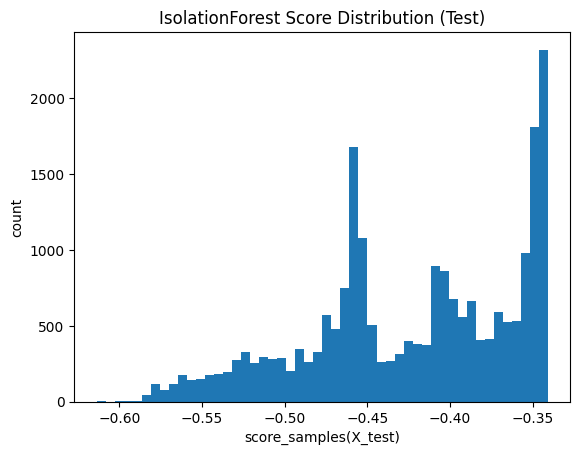

ROC-AUC: 0.893
PR-AUC:  0.898
Top 10 most anomalous test indices and scores:
22003 0.5919972574209841
9055 0.5923021615503045
2597 0.5923021615503045
22095 0.5924374476482422
16011 0.5930710675677011
11765 0.5935062685976292
14150 0.5942496258877745
3803 0.5998704959433252
1003 0.6108169862561833
16859 0.6136359109626273


In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

# 1. Get raw anomaly scores (higher → more “normal”)
scores_train = iso_forest.score_samples(X_train)
scores_test  = iso_forest.score_samples(X_test)

# 2. Inspect the decision threshold used internally
threshold = iso_forest.offset_
print(f"Internal decision threshold (offset_): {threshold:.4f}")

# 3. Plot score distribution on test set
plt.hist(scores_test, bins=50)
plt.title("IsolationForest Score Distribution (Test)")
plt.xlabel("score_samples(X_test)")
plt.ylabel("count")
plt.show()

# 4. Compute ranking metrics
#    Note: for ROC-AUC, we invert the score so that larger → more anomalous
y_scores = -scores_test
roc_auc = roc_auc_score(y_test, y_scores)
pr_auc  = average_precision_score(y_test, y_scores)

print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC:  {pr_auc:.3f}")

# 5. List top 10 most anomalous samples
top_idx = np.argsort(y_scores)[-10:]
print("Top 10 most anomalous test indices and scores:")
for idx in top_idx:
    print(idx, y_scores[idx])


## Prediction for new case

To predict a new case using an already trained model, we need to provide the exact same number of features.

In [195]:
import pandas as pd
import numpy as np

# Assume these objects already exist from your training pipeline:
#  - iso_forest          : fitted IsolationForest
#  - scaler              : fitted MinMaxScaler (or StandardScaler, etc.)
#  - categorical_cols    : ['protocol_type','service','flag']
#  - numeric_cols        : list of your numeric column names after encoding
#  - all_feature_cols    : list(X_train.columns)  # full ordered list of columns

categorical_cols = ['protocol_type','service','flag']
all_feature_cols = X_train.columns

def predict_new_case(case_dict):
    """
    Given a dict of raw feature values for one case,
    returns 'attack' or 'normal'.
    """
    # 1. Build a single-row DataFrame
    df_case = pd.DataFrame([case_dict])

    # 2. One-hot encode categorical columns
    df_case_enc = pd.get_dummies(df_case, columns=categorical_cols)

    # 3. Reindex to full feature set, filling any missing dummies with 0
    df_case_enc = df_case_enc.reindex(columns=all_feature_cols, fill_value=0)

    # 4. Scale numeric columns in place
    df_case_enc[numeric_cols] = scaler.transform(df_case_enc[numeric_cols])

    # 5. Predict with IsolationForest
    pred = iso_forest.predict(df_case_enc)  # array of [+1] or [-1]

    # 6. Map to human-readable label
    return 'attack' if pred[0] == -1 else 'normal'

# Example usage:
new_sample = {
    'duration':   10,
    'protocol_type': 'tcp',
    'service':    'http',
    'flag':       'SF',
    'src_bytes':  300,
    'dst_bytes':  1500,
    # … include all other numeric feature keys …
}

result = predict_new_case(new_sample)
print(f"The new case is predicted as: {result}")


KeyError: "['difficulty_level'] not in index"

## Estimate probability for new case knowing only some of the features

In [196]:
import pandas as pd

def estimate_attack_probability(df, feature_dict, target_col='label'):
    """
    Estimate P(attack | feature_dict) from DataFrame df.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain the target column and keys of feature_dict.
    feature_dict : dict
        e.g. {'protocol_type':'tcp', 'service':'http', 'flag':'SF'}
    target_col : str
        Name of the column holding attack labels, where 'normal' means non-attack.

    Returns
    -------
    pandas.Series
        Relative frequencies of each label within the matching subset.
        You can read P(attack) as 1 - prob['normal'], or look up specific attack names.
    """
    # 1. Build mask for all conditions
    mask = pd.Series(True, index=df.index)
    for col, val in feature_dict.items():
        mask &= (df[col] == val)

    # 2. Subset the DataFrame
    subset = df[mask]
    if subset.empty:
        return pd.Series(dtype=float)  # no matching rows

    # 3. Compute normalized value counts on the label column
    probs = subset[target_col].value_counts(normalize=True)
    return probs

# Example usage:
feature_obs = {'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF'}
probabilities = estimate_attack_probability(df_train, feature_obs)

print("Conditional label probabilities for", feature_obs)
print(probabilities)
print(f"P(attack) = {1 - probabilities.get('normal', 0):.3f}")


Conditional label probabilities for {'protocol_type': 'tcp', 'service': 'http', 'flag': 'SF'}
label
normal     0.975755
back       0.024077
phf        0.000112
ipsweep    0.000028
satan      0.000028
Name: proportion, dtype: float64
P(attack) = 0.024
